# Lecture 8: Simulation

## Learning Goals

- Generate a random sample from a discrete distribution in both `R` and `Python`.
- Reproduce the same random sample each time you re-run your code in either `R` or `Python` by setting the seed or random state. 
- Evaluate whether or not a set of observations are independent and identically distributed (*iid*).
- Use simulation to approximate distribution properties (e.g., mean and variance) using empirical quantities, especially for random variables involving multiple other random variables.
- Argue why simulations can approximate true properties of a stochastic quantity.

```{important} 
So far, we have seen many quantities that help us communicate an uncertain outcome:

- Probability.
- Probability mass function.
- Odds.
- Mode.
- Entropy.
- Mean.
- Variance/standard deviation.

Sometimes, it is not easy to compute these quantities in a given random process, system, or population of interest. We might have different random variables interacting, which poses challenges in the corresponding process of **estimation**. Therefore, in these situations, we can use **simulation** to approximate these and other quantities. This is today's topic. The notes will illustrate how to run basic simulations using either `R` or `Python`.
```

Specifically, we will use the `Python` packages [`numpy`](https://numpy.org/) and [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html):

In [1]:
%load_ext rpy2.ipython

import numpy as np
import scipy.stats

Now, we load the necessary `R` packages:

In [2]:
%%R 

library(tidyverse)
library(lubridate)
library(testthat)
library(janitor)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘testthat’

The following object is masked from ‘package:dplyr’:

    matches

The following object is masked from ‘package:purrr’:

    is_null

The following objects are masked from ‘package:readr’:

    edition_get, local_edition

The following object is masked from ‘package:tidyr’:

    matches


Attaching package: ‘janitor’

The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



## 1. Review on Random Samples

From {doc}`07_lecture-maximum-likelihood-estimation`, we know that a **random sample** is a collection of random outcomes/variables. Using mathematical notation, a random sample of size $n$ is usually depicted as $X_1, \ldots, X_n$. We think of data as being part of a random sample. 

Some examples of random samples are listed as follows: 

- The first five items you get in a game of Mario Kart ($n = 5$).
- The outcomes of ten dice rolls ($n = 10$).
- The daily high temperature in Vancouver for each day of the year ($n = 365$).

Also, recall that **unless we make additional sampling assumptions**, a **default** random sample is said to be **independent and identically distributed** (or **iid**) if:

1. Each pair of observations are independent, and
2. each observation comes from the same distribution.

Sometimes, when an outcome is said to be **random**, this can either mean the outcome has some distribution (**with non-zero entropy**) or the distribution with maximum entropy. To avoid confusion, the word **stochastic** refers to the former (as having some uncertain outcome). For example, if a die is weighted so that "1" appears very often, would you call this die "random"? Whether or not you do, it is always **stochastic**. 
The opposite of stochastic is **deterministic**: an outcome that will be known with 100% certainty.

## 2. Seeds

Computers cannot actually generate truly random outcomes. Instead, they use something called [**pseudorandom numbers**](https://en.wikipedia.org/wiki/Pseudorandom_number_generator). As an example of a basic algorithm that produces pseudo-random numbers between 0 and 1, consider starting with your choice of number $x_0$ between $0$ and $1$, and iterating the following equation:

$$x_{i+1} = 4 x_i (1 - x_i).$$

The result will appear to be random numbers between $0$ and $1$. For example, here is the resulting sequence when we start with $x_0 = 0.3$ and iterate 1000 times:

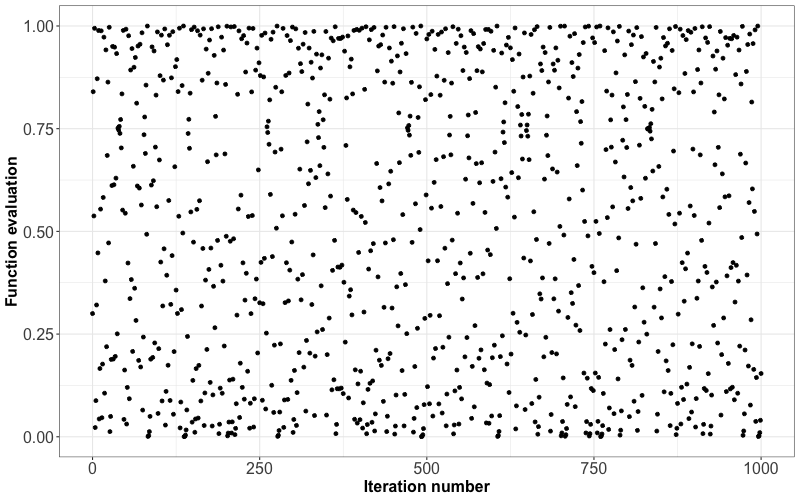

In [3]:
%%R -w 800 -h 500

n <- 1000
x <- 0.3
for (i in 1:n) x[i + 1] <- 4 * x[i] * (1 - x[i])
suppressMessages(suppressWarnings(print(qplot(0:n, x) +
  labs(
    x = "Iteration number",
    y = "Function evaluation"
  ) +
  theme_bw() +
  theme(
    plot.title = element_text(size = 17, face = "bold"),
    axis.text = element_text(size = 16),
    axis.title = element_text(size = 16, face = "bold"),
    legend.title=element_text(size = 16, face = "bold"), 
    legend.text=element_text(size = 16)
  ))))

Although this sequence is deterministic, it behaves like a random sample. But not entirely! All pseudorandom number generators have some pitfalls. In the case above, one pitfall is that **neighbouring pairs are not independent of each other** (by definition, of the way the sequence was set up!). However, some sophisticated algorithms produce outcomes that more closely resemble a random sample, so most of the time, we do not have to worry about the sample not being truly random.

```{admonition} Definition of Seed
:class: tip
The **seed** (or **random state**) in a pseudo-random number generator is some pre-specified initial value that determines the generated sequence. 

As long as the seed remains the same, the resulting sample will also be the same. In the case above, this is $x_0 = 0.3$. In `R` and `Python`, if we do not explicitly set the seed, then the seed will be chosen for us.
```

In `R`, we can set the seed using the [`set.seed()`](https://www.statology.org/set-seed-in-r/) function, and in `Python`, using the [`numpy.random.seed()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html) function from `numpy`.

```{important} 
The seed gives us an added advantage over truly random numbers: it allows our analysis to be **reproducible**! If we explicitly set a seed, then someone who re-runs the analysis will get the same results. 
```

## 3. Generating Random Samples: Code

We will look at some `R` and `Python` functions that help us generate a random sample. Note we are still focusing on discrete distributions here.

### 3.1. From Finite Number of Categories

In `R`, we can generate a random sample from a **discrete distribution** with a finite number of outcomes using the [**`sample()` function**](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/sample). It works as follows:
- Put the outcomes as a vector in the first argument, `x`.
- Put the desired sample size in the argument `size`.
- Put `replace = TRUE` **so that sampling can happen with replacement**.
- Put the probabilities of the outcomes as a vector respective to `x` in the argument `prob`.

```{important} 
If these probabilities do not add up to 1, `R` will not throw an error. Instead, `R` automatically adjusts the probabilities so that they add up to 1.
```

Here is an example of generating $n = 10$ items using the Mario Kart item distribution from {doc}`01_lecture-uncertainty`. Notice that the seed is set so that every time these lecture notes are rendered, the same results are obtained.

In [4]:
%%R -o R_mario_sample

set.seed(551)
outcomes <- c("banana", "bob-omb", "coin", "horn", "shell")
probs <- c(0.12, 0.05, 0.75, 0.03, 0.05)
n <- 10
R_mario_sample <- sample(outcomes, size = n, replace = TRUE, prob = probs)

In [5]:
# Showing R output in Python environment
R_mario_sample

array(['banana', 'coin', 'coin', 'coin', 'coin', 'coin', 'coin', 'coin',
       'coin', 'coin'], dtype='<U6')

In `Python`, we can generate a random sample from a discrete distribution using the [**`numpy.random.choice()` function**](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html). It works as follows:

- Put the outcomes in the first argument, `a`.
- Put the desired sample size in the argument `size`.
- Put the probabilities of the outcomes respective to `x` in the argument `p`.

Using the Mario Kart example again, we have the following:

In [6]:
# Python

np.random.seed(551)
outcomes = ["banana", "bob-omb", "coin", "horn", "shell"]
probs = [0.12, 0.05, 0.75, 0.03, 0.05]
n = 10
np.random.choice(a = outcomes, size = n, p = probs)

array(['coin', 'banana', 'coin', 'coin', 'coin', 'coin', 'coin', 'coin',
       'coin', 'coin'], dtype='<U7')

```{important} 
In `numpy.random.choice()`, it is necessary that the probabilities in `prob` add up to 1.

Moreover, note that both `R` and `Python` have their own algorithms to generate pseudorandom outcomes, **even though we provide the same seed**.
```

### 3.2. From Distribution Families

In `R`, we can generate data from a distribution belonging to some parametric family using the `rdist()` function, where "`dist`" is replaced with a short form of the distribution family's name. We can access the corresponding probability mass function (PMF) or probability distribution function (PDF) with `ddist()`.
In `Python`, we can use the `stats` module from the `scipy` library.

{numref}`random-functions` summarizes the functions related to some of the discrete distribution families we have seen.

```{list-table} Summary of Random Numbers Generators
:header-rows: 1
:name: random-functions

* - Family
  - `R` Function
  - `Python` Function
* - Binomial
  - `rbinom()`
  - `scipy.stats.binom.rvs()`
* - Geometric
  - `rgeom()`
  - `scipy.stats.geom.rvs()`
* - Negative Binomial
  - `rnbinom()`
  - `scipy.stats.nbinom.rvs()`
* - Poisson
  - `rpois()`
  - `scipy.stats.poisson.rvs()`
```

The corresponding functions for continuous random variables can be found in {ref}`cont-r-functions`.
We can use these functions as follows:

- **Sample size $n$**: 
	- For `R`, put this in the argument `n`, which comes first.
	- For `Python`, put this in the argument `size`, which comes last. 
- In both languages, each parameter has its own argument. Sometimes, like in `R`'s `rnbinom()`, there are more parameters than needed, giving the option of different parameterizations. Be sure only to specify the exact number of parameters required to isolate a member of the distribution family!

Let us start with a **Binomial exercise**. We will obtain $n = 10$ random numbers from a Binomial distribution with probability of success $p = 0.6$ and 5 trials.

```{important} 
Let us not confuse the random sample size $n$ (i.e., the number of Binomial random numbers in our sample, such as `n` in the `R` function) with the number of trials $n$ as a parameter of the standalone Binomial random variable (i.e., `size` in `rbinom()`).

For `Python`, the Binomial parameter $n$ is actually depicted as `n` and `size` is the number of Binomial random numbers in our sample.
```

`R` function `rbinom()` generates these random numbers. In this case, the argument `prob` refers to $p$ and `n` for the desired amount of random numbers. The parameter $n$ of the Binomial distribution is referred to as `size`.

In [7]:
%%R -o rbinom_output

set.seed(551)
rbinom_output <- rbinom(n = 10, size = 5, prob = 0.6)

In [8]:
# Showing R output in Python environment
rbinom_output

array([2, 4, 3, 4, 2, 4, 5, 3, 4, 4], dtype=int32)

On the other hand, `Python` uses the argument `p` for $p$ and `size` for the desired amount of random numbers. The parameter $n$ of the Binomial distribution is referred to as `n`.

In [9]:
# Python

np.random.seed(551)
scipy.stats.binom.rvs(n = 5, p = 0.6, size = 10)

array([3, 5, 3, 2, 2, 3, 4, 2, 2, 3])

Note that this is a particularly confusing example because `size` in the `R` code means the parameter $n$ of the Binomial distribution, whereas `size` in the Python code means the number of random samples, also known as the sample size, that you want it to generate.

**Let us proceed with a Negative Binomial example.** The Negative Binomial family is an example of a function in `R` that allows different parameterizations. Suppose the following:

$$X \sim \text{Negative Binomial} (k, p),$$

where $X$ refers to the number of failures in independent successive Bernoulli trials before experiencing $k$ successes with probability $p$.

`R` function `rnbinom()` generates `n` Negative Binomial-distributed random numbers with arguments `size` as $k = 5$ and `prob` as $p = 0.6$:

In [10]:
%%R -o rnbinom_output

set.seed(551)
rnbinom_output <- rnbinom(n = 10, size = 5, prob = 0.6)

In [11]:
# Showing R output in Python environment
rnbinom_output

array([5, 0, 2, 2, 2, 5, 4, 0, 4, 8], dtype=int32)

Now let us check a second case using `rnbinom()`. Recall the expected value is
```{math}
\mu = \mathbb{E}(X) = \frac{k(1 - p)}{p} = \frac{5(1 - 0.6)}{0.6} = 3.33.
```

From {doc}`02_lecture-parametric-families`, we know that a distribution can also be parameterized with its corresponding mean. For a Negative Binomial-distributed random number, the argument `mu` `rnbinom()` refers to the expected value $\mu$ from above. Hence, we either use `prob` or `mu` in the `rnbinom()` function. If we want to use `mu`, then we will need to provide the following:


In [12]:
%%R -o rnbinom_output_mu

set.seed(551)
rnbinom_output_mu <- rnbinom(n = 10, size = 5, mu = 3.33)

In [13]:
# Showing R output in Python environment
rnbinom_output_mu

array([5., 0., 2., 2., 2., 5., 4., 0., 4., 8.])

We get the same random numbers via the same seed!

```{exercise}
:label: lecture8-q1

Suppose you want to simulate hourly bank branch queues of customers. Historically, hourly queues show an average of 10 people. 

What distribution (including parametrization) and `R` random number generator will you use to simulate 20 random numbers?

Select the correct option:

**A.** $\text{Poisson}(\lambda = 1/10)$ with `rpois(n = 20, lambda = 1 / 10)`

**B.** $\text{Binomial}(n = 10, p = 1/10)$ with `rbinom(n = 20, size = 10, prob = 1 / 10)`

**C.** $\text{Poisson}(\lambda = 10)$ with `rpois(n = 20, lambda = 10)`

**D.** $\text{Geometric}(p = 1/10)$ with `rgeom(n = 20, prob = 1 / 10)`
```

```{exercise}
:label: lecture8-q2

During a random foodie tour, suppose you want to simulate the number of non-authentic Mexican restaurants you will try before encountering your very first authentic one in Vancouver. Overall, it is known that 70% of Mexican restaurants in Vancouver are considered non-authentic (but you do not have access to this list!).

What distribution (including parametrization) and `R` random number generator will you use to simulate 15 random numbers?

Select the correct option:

**A.** $\text{Binomial}(n = 15, p = 0.7)$ with `rbinom(n = 15, size = 15, prob = 0.7)`

**B.** $\text{Geometric}(p = 0.3)$ with `rgeom(n = 15, prob = 0.3)`

**C.** $\text{Binomial}(n = 15, p = 0.3)$ with `rbinom(n = 15, size = 15, prob = 0.3)`

**B.** $\text{Geometric}(p = 0.7)$ with `rgeom(n = 15, prob = 0.7)`
```

## 4. Running Simulations

So far, we have seen two ways to calculate quantities that help us communicate uncertainty (like means and probabilities):
1. The **distribution-based approach** (using the distribution), resulting in **true values**.
2. The **empirical approach** (using data), resulting in **approximate values** that improve as the sample size increases (**i.e., the frequentist paradigm!**).

For example, the **true** mean of a discrete random variable $X$ can be calculated as 
```{math}
\mathbb{E}(X) = \sum_x x \cdot P(X = x),
```

using each pair of outcome and outcome's probability, or can be approximated using the empirical approach from a random sample $X_1, \ldots, X_n$ by 
```{math}
\mathbb{E}(X) \approx \frac{1}{n} \sum_{i=1}^n X_i.
```

This means that we can approximate these quantities by generating a sample! An analysis that uses a randomly generated data set is called a **simulation**. 

### 4.1. Code for Empirical Quantities

Here are some hints for calculating empirical quantities using `R` functions for your reference. We will be going over these below in the next section:
- `mean()` calculates the sample average

```{math}
\bar{X} = \frac{1}{n} \sum_{i=1}^n X_i.
```

- `var()` calculates the sample variance (the $n - 1$ version, not $n$)
```{math}
S^2 = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})^2
```

- `sd()` its square root for the sample standard deviation.
- `quantile()` calculates the empirical $p$-quantile, which is the $np$'th largest (rounded up) observation in a sample of size $n$.
- For a single probability, remember that a mean is just an average. Just calculate the mean of a condition.
- For an entire PMF, use the `table()` function, or more conveniently, the `janitor::tabyl()` function.
- For the mode, either get it manually using the `table()` or `janitor::tabyl()` function, or you can use `DescTools::Mode()`.

### 4.2. Basic Simulation

In Mexico City, consider a **random person** dating via **some given app** with a probability of having a successful date of $0.7$. Suppose we want to evaluate the success of this given app via the **number of failed dates** before they experience $5$ **successful dates**.

``` {figure} img/angel.jpg
:height: 500px
:name: angel
[The Angel of Independence](https://en.wikipedia.org/wiki/Angel_of_Independence), one of the most famous landmarks in Mexico City with a [Jacaranda tree](https://mexiconewsdaily.com/news/purple-spring-5-fun-facts-about-jacarandas/) closeup (photo by <a href="https://unsplash.com/@axelgarcia?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Axel García</a> on <a href="https://unsplash.com/photos/yWgIfYgwVfA?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>)
```

We can translate the above inquiry as a random variable denoting failed dates has a Negative Binomial distribution:

```{math}
\begin{gather*}
X = \text{Number of failed dates before experiencing 5 successful ones} \\
X \sim \text{Negative Binomial} (k = 5, p = 0.7) \quad \text{for } x = 0, 1, 2, ...
\end{gather*}
```

Let us demonstrate both a distribution-based and empirical approach to compute the variance and PMF. First, let us obtain our random sample (of, say, $n = 10000$ observations).

In [14]:
%%R -o random_sample

set.seed(551)
k <- 5
p <- 0.7
n <- 10000
random_sample <- rnbinom(n, size = k, prob = p)

In [15]:
# Python environment
# Showing random numbers in vector random_sample
random_sample

array([3, 0, 1, ..., 1, 3, 4], dtype=int32)

#### 4.2.1. Mean

**Theoretically**, the mean of $X$ is
```{math}
\mathbb{E}(X) = \frac{k(1 - p)}{p}.
```

We compute it as follows:

In [16]:
%%R

(k * (1 - p)) / p

[1] 2.142857


**Empirically**, we can approximate $\mathbb{E}(X)$ with the mean of the values in `random_sample`:

In [17]:
%%R

mean(random_sample)

[1] 2.1696


**Note the above empirical value is quite close to the theoretical one!**

#### 4.2.2. Variance

**Theoretically**, the variance of $X$ is

```{math}
\text{Var}(X) = \frac{k(1 - p)}{p^2}.
```

We compute it as follows:

In [18]:
%%R

(k * (1 - p)) / p^2

[1] 3.061224


**Empirically**, we can approximate $\text{Var}(X)$ with the sample variance of the values in `random_sample`:

In [19]:
%%R

var(random_sample)

[1] 3.170153


**Note the above empirical value is quite close to the theoretical one!**

#### 4.2.3. Standard deviation

**Theoretically**, the standard deviation of $X$ is

```{math}
\text{sd}(X) = \sqrt{\frac{k(1 - p)}{p^2}}.
```

We compute it as follows:

In [20]:
%%R

sqrt((1 - p) * k / p^2)

[1] 1.749636


**Empirically**, we can approximate $\text{sd}(X)$ with the sample standard deviation of the values in `random_sample`:

In [21]:
%%R

sd(random_sample)

[1] 1.780492


**Note the above empirical value is quite close to the theoretical one!**

#### 4.2.4. Probability of Seeing $0$ Failures (i.e., $0$ failed dates!)

**Theoretically**, this probability can be computed as

```{math}
P(X = 0 \mid k, p) = {k - 1 \choose 0} p^k (1 - p)^x.
```

We can automatically compute this probability via the density function `dnbinom()` as follows:

In [22]:
%%R

dnbinom(x = 0, size = k, prob = p)

[1] 0.16807


**Empirically**, we can approximate $P(X = 0 \mid k, p)$ by counting the number of random numbers equal to $0$ in `random_sample` and dividing this count over the sample size $n = 10000$. We can quickly do this via logical values as follows:

In [23]:
# Python environment
# Showing random numbers in vector random_sample
random_sample

array([3, 0, 1, ..., 1, 3, 4], dtype=int32)

In [24]:
# Python environment
# Showing logical values for condition "== 0"
random_sample == 0

array([False,  True, False, ..., False, False, False])

In [25]:
%%R

# Using function mean() to empirically compute P(X = 0)
mean(random_sample == 0) 

[1] 0.1655


#### 4.2.5. Probability Mass Function

Just as we did it with $P(X = 0 \mid k, p)$, we can also do it for $P(X = i \mid k, p)$ with $i = 1, 2, \dots$ (i.e., **the whole PMF!**). Nonetheless, let us use functions from `tidyverse` and `tabyl()` from `janitor`. We will create a table containing columns for both approaches: **theoretical** (using `dnbinom()`) and **empirical** (using `random_sample`).

In [26]:
%%R -o PMF

PMF <- tabyl(random_sample) %>%
  select(x = random_sample, Empirical = percent) %>%
  mutate(Theoretical = dnbinom(x, size = k, prob = p))
PMF <- PMF %>%
  mutate(
    Theoretical = round(Theoretical, 4),
    Empirical = round(Empirical, 4)
  )

In [27]:
# Python environment
# Showing PMF in a more Jupyter book-friendly format
PMF

,x,Empirical,Theoretical
1,0,0.1655,0.1681
2,1,0.2541,0.2521
3,2,0.2250,0.2269
4,3,0.1545,0.1588
5,4,0.0966,0.0953
6,5,0.0534,0.0515
7,6,0.0263,0.0257
8,7,0.0133,0.0121
9,8,0.0060,0.0055
10,9,0.0041,0.0024


**Note that both probability columns are similar!** 

Now, we can also plot both PMFs:

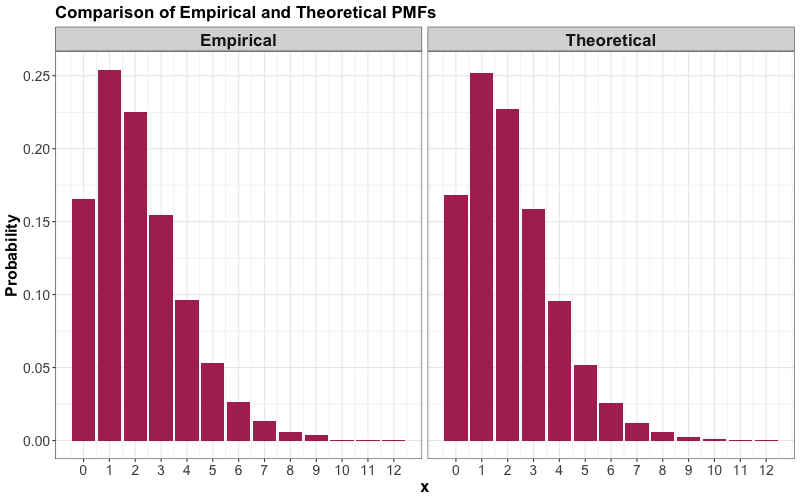

In [28]:
%%R -w 800 -h 500

PMF %>%
  gather(key = "method", value = "Probability", Empirical, Theoretical) %>%
  ggplot(aes(x, Probability)) +
  facet_wrap(~method) +
  geom_col(fill = "maroon") +
  theme_bw() +
  theme(plot.title = element_text(size = 17, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16, face = "bold"),
    strip.text.x = element_text(size = 17, face = "bold")) +
  ggtitle("Comparison of Empirical and Theoretical PMFs") +
  scale_x_continuous(breaks = 0:12) +
  scale_y_continuous(breaks = c(0, 0.05, 0.1, 0.15, 0.2, 0.25))

#### 4.2.6. Mode

Recall the mode is the outcome of the random variable with the largest probability. From our previous plots, we can see that the mode is $X = 1$. We can confirm this as follows:

In [29]:
%%R

## Theoretical
PMF %>%
  filter(Theoretical == max(Theoretical)) %>%
  pull(x)

[1] 1


In [30]:
%%R

## Empirical
PMF %>%
  filter(Empirical == max(Empirical)) %>%
  pull(x)

[1] 1


#### 4.2.7. Law of Large Numbers

The Law of Large of Numbers states that, as we increase our sample size $n$, our empirical mean converges to the **true mean** we want to estimate. That is, as we increase our $n$, our **sample average** $\bar{X}$ converges to the true mean $\mu$.

To demonstrate that a larger sample size improves the approximation of the empirical mean, let us see how this sample average changes as we collect more and more data. Given that

```{math}
X \sim \text{Negative Binomial} (k = 5, p = 0.7),
```

with

```{math}
\mathbb{E}(X) = \frac{k(1 - p)}{p} = 2.14.
```

The plot below shows that, as we increase our sample size $n$ of simulated random numbers, their corresponding empirical mean (i.e., **sample average**) converges to the $\mathbb{E}(X) = 2.14$ (horizontal dashed line) depicted as a red line.

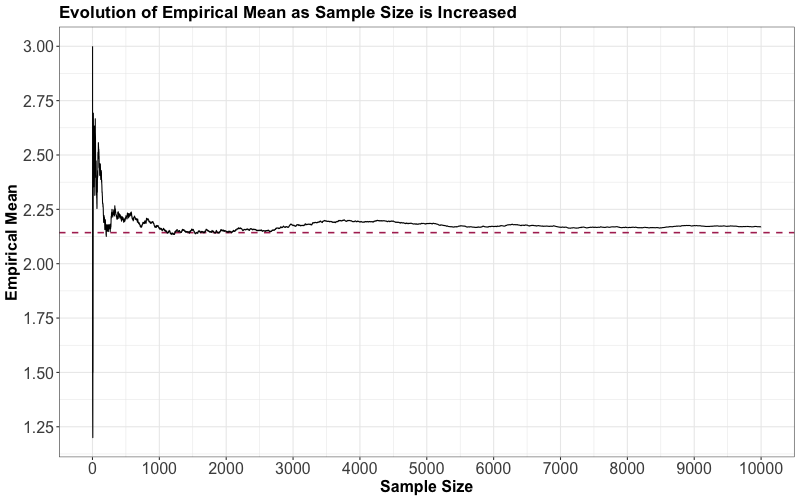

In [31]:
%%R -w 800 -h 500

suppressWarnings(print(tibble(
  i = 1:n,
  mean = cumsum(random_sample) / i
) %>%
  ggplot(aes(i, mean)) +
  geom_hline(
    yintercept = (1 - p) * k / p,
    colour = "maroon", linetype = "dashed", size = 0.75
  ) +
  geom_line() +
  labs(
    x = "Sample Size",
    y = "Empirical Mean"
  ) +
  theme_bw() +
  theme(plot.title = element_text(size = 17, face = "bold"),
    axis.text = element_text(size = 16),
    axis.title = element_text(size = 16, face = "bold"),
    strip.text.x = element_text(size = 17, face = "bold")) +
  ggtitle("Evolution of Empirical Mean as Sample Size is Increased") +
  scale_y_continuous(breaks = seq(0, 3, 0.25)) +
  scale_x_continuous(breaks = seq(0, 10000, 1000))))

## 5. Multi-Step Simulations

The simulation above was not all that useful, since we could calculate basically anything (theoretically speaking!). It gets more interesting when we want to calculate things for a random variable that transforms and/or combines multiple random variables.

The idea is that some random variables will have a distribution that depends on other random variables but in a way that is explicit. For example, consider a random variable $T$ that we can obtain as follows: 

```{math}
X \sim \text{Poisson}(\lambda = 5), 
```

and then 
```{math}
T = \sum_{i = 1}^{X} D_i,
```

where each $D_i$ are *iid* with some **specified distribution**. In this case, to generate $T$, you would first need to generate $X$, then generate $X$ values of $D_i$, then sum those up to get $T$. This is the example we will see here, but in general, you can have any number of dependencies, each component of which you would have to generate.

``` {figure} img/ship.png
:height: 350px
:name: ship
A cargo ship
```

Consider an example that a Vancouver port faces with **gang demand**. Whenever a ship arrives to the port of Vancouver, they request a certain number of **gangs** (groups of people) to help unload the ship. Let us suppose the number of gangs requested by a ship has the following **discrete distribution** (i.e., a PMF):

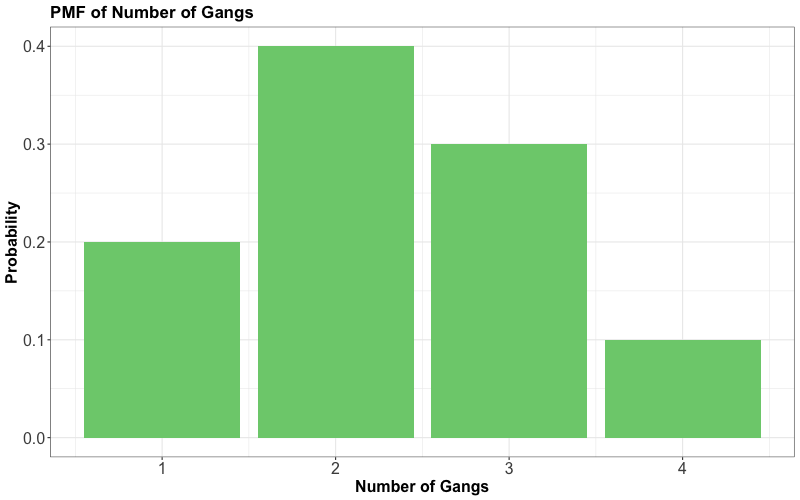

In [32]:
%%R -w 800 -h 500

gang <- 1:4
p <- c(0.2, 0.4, 0.3, 0.1)

tibble(
  gangs = gang,
  p     = p
) %>%
  ggplot(aes(gangs, p)) +
  geom_col(fill = "palegreen3") +
  labs(
    x = "Number of Gangs",
    y = "Probability"
  ) +
  theme_bw() +
  theme(plot.title = element_text(size = 17, face = "bold"),
    axis.text = element_text(size = 16),
    axis.title = element_text(size = 16, face = "bold"),
    strip.text.x = element_text(size = 17, face = "bold")) +
  ggtitle("PMF of Number of Gangs")

The following function sums up simulated gangs requested by a certain number of ships with the above probability distribution as a default:

In [33]:
%%R

#' Generate gang demand
#'
#' Simulates the GRAND TOTAL number of gangs requested, if each ship
#' requests a random number of gangs.
#' 
#' @param n_ships Number of ships that are making demands.
#' @param gangs Possible gang demands made by a ship.
#' @param prob Probabilities of gang demand corresponding to "gangs."
#' 
#' @return Number representing the total gang demand 
demand_gangs <- function(n_ships, gangs = gang, prob = p) {
  if (length(gangs) == 1) {
    gangs <- c(gangs, gangs)
    prob <- c(1, 1)
  }
  requests <- sample(
    gangs,
    size = n_ships,
    replace = TRUE,
    prob = prob
  )
  sum(requests)
}

# Testing our function (a Data Science-standard!)
test_that("demand_gangs output is as expected", {
  expect_identical(demand_gangs(0), 0L)
  expect_gte(demand_gangs(1), min(gang))
  expect_lte(demand_gangs(1), max(gang))
  expect_gte(demand_gangs(10), 10 * min(gang))
  expect_lte(demand_gangs(10), 10 * max(gang))
  expect_identical(length(demand_gangs(10)), 1L)
  expect_identical(demand_gangs(10, gangs = 2, prob = 1), 20)
})

Test passed 🌈


As an example, let us check out the simulated **grand total gang request** from 10 ships:

In [34]:
%%R

set.seed(551)
demand_gangs(n_ships = 10)

[1] 20


Suppose the number of ships arriving on a given day follows the Poisson distribution with a mean of $\lambda = 5 \text{ ships}$. Now, this is our main statistical inquiry: **what is the distribution of total gang requests on a given day?** 

Let us simulate the process to find out:

1. Generate arrival quantities for $n$ days from the $\text{Poisson}(\lambda = 5 \text{ ships})$ distribution.
2. For each day, simulate **the grand total gang request** for the simulated number of ships.
3. You now have your random sample of size $n$ -- compute things as you normally would.

We will try this by obtaining **a sample of $n = 10000$ days**:

In [35]:
%%R -o simulation_outputs

n_days <- 10000

# Setting global seed!
set.seed(551)

## Step 1: generate a bunch of ships arriving each day.
arrivals <- rpois(n_days, lambda = 5)

## Step 2: Simulate the grand total gang request on each day.
total_requests <- purrr::map_int(arrivals, demand_gangs)

## Step 3: Compute mean and variance.
simulation_outputs <- tibble(
  mean = mean(total_requests),
  variance = var(total_requests)
)

In [36]:
# Python environment
# Showing simulation outputs in a more Jupyter book-friendly format
simulation_outputs

,mean,variance
1,11.5393,31.650421


From our 10,000 replicates, the summary statistics above indicate that **we typically expect a demand of 11.5393 gangs on a given day in the whole port**.

Nonetheless, **our distribution is slightly right-skewed**, meaning that gang demand leans towards less than this mean. We can check it out by plotting our simulation results stored in `total_requests` (**mean gang request is indicated as a solid vertical blue line**):

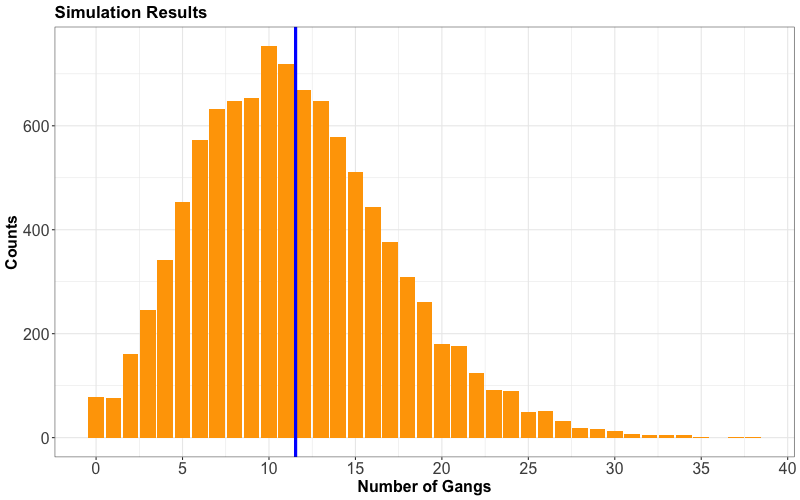

In [37]:
%%R -w 800 -h 500

total_requests <- data.frame(sim = total_requests)

ggplot(total_requests, aes(sim)) +
  geom_bar(fill = "orange") +
  labs(
    x = "Number of Gangs",
    y = "Counts"
  ) +
  theme_bw() +
  theme(plot.title = element_text(size = 17, face = "bold"),
    axis.text = element_text(size = 16),
    axis.title = element_text(size = 16, face = "bold"),
    strip.text.x = element_text(size = 17, face = "bold")) +
  ggtitle("Simulation Results") +
  scale_x_continuous(breaks = seq(0, 40, 5)) +
  geom_vline(xintercept = 11.5393, color = "blue", size = 1.5)